# Fit spline

In [1]:
# Standard imports
import numpy as np
import cv2
from matplotlib import pyplot as plt
from typing import *

In [2]:
# spline_interpolations.py provides some spline interpolation methods
# (see its code)
from spline_interpolations import *

In [3]:
# Define some types synomyms for clarity
Point2D = np.ndarray # shape = (1, 2)
PointsArray = np.ndarray # Liste de points, shape = [n, 2]

# Utilitaires
On définit des fonctions de dessin de splines interpolees avec leur point de controle:

In [4]:
def _plot_pixels_array(ax, points: PointsArray, style):
    """
    This will plot a PointsArray (private function)
    """
    x = points[:,0]
    y = points[:,1] * -1
    ax.plot(x, y, style) 

    
def plot_control_and_interpolate(control_points: PointsArray, interpolated_points: PointsArray, title:str = ""):
    """
    This will plot some control points and their interpolate + a title
    """
    fig, ax = plt.subplots(1, 1) 
    _plot_pixels_array(ax, control_points, 'or')
    _plot_pixels_array(ax, interpolated_points, '-b')
    fig.suptitle(title)

def plot_curve(curve: PointsArray, title:str = ""):
    """
    This will plot a curve + a title
    """
    fig, ax = plt.subplots(1, 1) 
    _plot_pixels_array(ax, curve, '-b')
    fig.suptitle(title)    

# Fonctions d'interpolation de splines
On dispose de deux fonctions d'interpolation, `interpolate_centripetal_catmull_rom_circular_shape` et `interpolate_pascal_spline_circular_shape` qui permettent d'interpoler des points de controle vers une form circulaire "douce".
Elles sont définies dans spline_interpolations.py

Par exemple, étant donné les points:

In [5]:
control_points = np.array(
        [
            [0., 0.],
            [1., 0.],
            [1., 1.],
            [0., 1.],
        ]
    )

On peut avoir les interpolées ci-dessous:

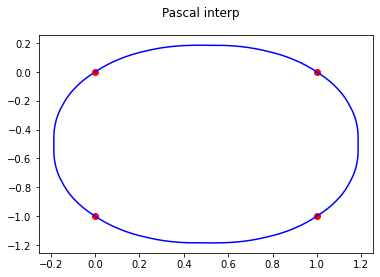

In [6]:
nb_points_to_interpolate = 200
alpha = 0.4
interpolated_points = interpolate_pascal_spline_circular_shape(control_points, nb_points_to_interpolate, alpha)
plot_control_and_interpolate(control_points, interpolated_points, "Pascal interp")

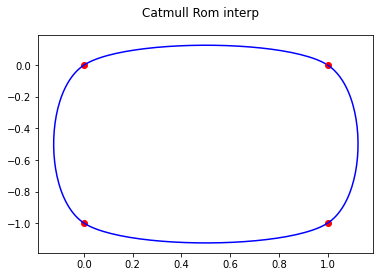

In [7]:
nb_points_to_interpolate = 200
alpha = 0.4
interpolated_points = interpolate_centripetal_catmull_rom_circular_shape(control_points, nb_points_to_interpolate, alpha)
plot_control_and_interpolate(control_points, interpolated_points, "Catmull Rom interp")

# Collection de formes

On dispose de plusieurs formes typiques:


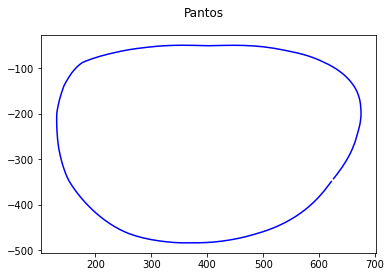

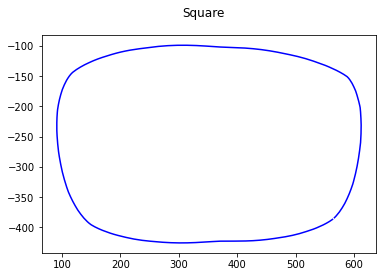

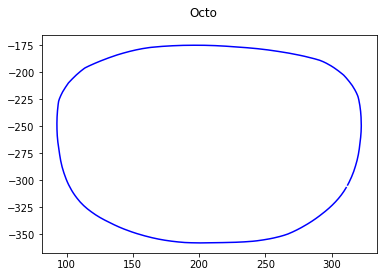

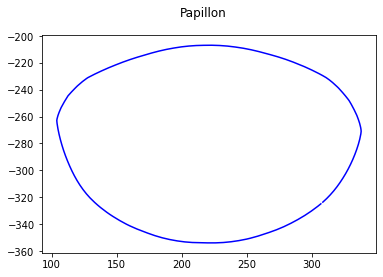

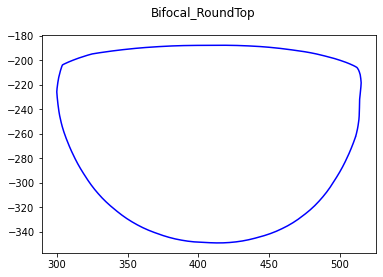

In [8]:
for shape_name, curve in typical_shapes().items():
    plot_curve(curve, shape_name)

# Le problème: fitspline

On cherche les fonctions inverses (appelée `fit_spline_*`) qui permettent, étant donnée une courbe avec beaucoup de points (les courbes en bleu ci-dessus) de trouver un bon ensemble de points de contrôle permettant d'approximer la courbe avec une de ces deux méthodes d'interpolation.

Leur signature doit être:

In [9]:
def fit_spline_pascal(
    curve: PointsArray,
    nbControlPoints: int,
    alpha: float
  ) -> PointsArray:

    """ 
    fit_spline_pascal renvoie nb_control_points permettant d'approximer la courbe 
    avec l'interpolation interpolate_pascal_spline_circular_shape
    """
    pass


def fit_spline_catmull_rom(
     curve: PointsArray,
    nbControlPoints: int,
    alpha: float
  ) -> PointsArray:
    """idem avec interpolate_centripetal_catmull_rom_circular_shape"""

    

On essaiera d'abord d'implémenter fit_spline_catmull_rom, puis on pourra généraliser à plusieurs types d'interpolation.

Par exemple, on pourra essayer d'approximer la forme ci-dessous:

In [10]:
my_curve = typical_shapes()["Pantos"]

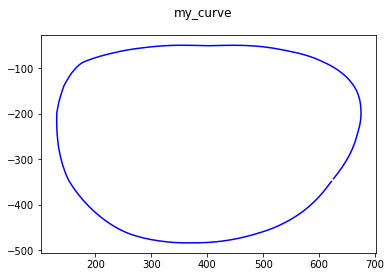

In [11]:
plot_curve(my_curve, "my_curve")

In [12]:
# Ci dessous le contenu de my_shape
print(my_curve.shape)
print(my_curve[0:5,])

(256, 2)
[[622.         349.        ]
 [619.05060858 353.8211296 ]
 [616.10941723 358.64732134]
 [613.12057815 363.44350869]
 [610.06934849 368.20002836]]


In [13]:
def curve_to_01_function(curve):
    """
    curve_to_01_function transform a curve (PointsArray) into a function
    that transform values in [0, 1] to points on the curve
    """
    nb_points = curve.shape[0]
    def f(x):
        """
        Takes a value in the interval [0,1[ and returns a point on the curve
        """
        if x < 0.:
            x = 0.
        if x > 1.:
            x = 1.
        x = x * nb_points

        # linear interpolation between the two closest points on the curve
        i0 = int(x)
        i0 = i0 if i0 < nb_points else 0
        k0 = 1.0 - (x - i0)
        pt0 = curve[i0]

        i1 = i0 + 1
        i1 = i1 if i1 < nb_points else 0
        k1 = 1 - k0
        pt1 = curve[i1]

        pt = pt0 * k0 + pt1 * k1
        return pt
    return f
 

In [14]:
# Let transform our curve to a function
my_f_curve = curve_to_01_function(my_curve)
# and see its value a 0. and 0.9999 (they should match the shape ends)
print(my_f_curve(0.))
print(my_f_curve(0.9999))

[622. 349.]
[622.10089844 348.84214457]


In [15]:
FloatValues = np.ndarray

def make_control_points(xs: FloatValues, curve_01_f):
    """
    Given a set of values in the interval [0, 1[, return points on the curve.
    They are possible control points on the curve
    """
    nb_control_points = xs.shape[0]
    curve_points = np.zeros((nb_control_points, 2))
    for i in range(nb_control_points):
        curve_points[i] = curve_01_f(xs[i])
    return curve_points

In [16]:
my_initial_guess = np.linspace(0., 1., num=5, endpoint=False)
print(my_initial_guess)
my_control_points = make_control_points(my_initial_guess, my_f_curve)
print (my_control_points)

[0.  0.2 0.4 0.6 0.8]
[[622.         349.        ]
 [353.82345731 484.08823862]
 [142.73014754 317.4989937 ]
 [160.99705199 104.91144251]
 [516.27451013  55.06185287]]


In [17]:
def make_curve_from_control_points(control_points):
    interpolated_curve = interpolate_centripetal_catmull_rom_circular_shape(control_points, 300, 0.4)
    return interpolated_curve

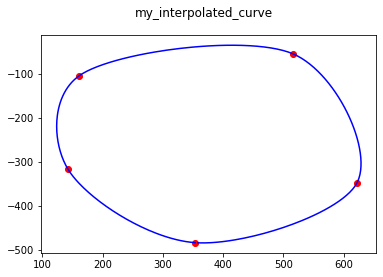

In [18]:
my_interpolated_curve = make_curve_from_control_points(my_control_points)
plot_control_and_interpolate(my_control_points, my_interpolated_curve, "my_interpolated_curve")

In [19]:
def curve_distances_slow(curve1: PointsArray, curve2: PointsArray):
    # *Slow* algo to calculate the distance between curves
    total_dist = 0
    for pt1 in curve1:
        min_dist_this_point = 1E9
        for pt2 in curve2:
            dist = np.linalg.norm(pt2 - pt1)
            if dist < min_dist_this_point:
                min_dist_this_point = dist
        total_dist = total_dist + min_dist_this_point
        total_dist = total_dist / pt1.shape[0]
    return total_dist

def curve_distances(curve1: PointsArray, curve2: PointsArray):
    ### Faster version, using numpy
    total_dist = 0
    for pt1 in curve1:
        diff = curve2 - pt1
        diff_norm = np.linalg.norm(diff, axis = 1)
        dist = diff_norm[diff_norm.argmin()]
        total_dist = total_dist + dist
    total_dist = total_dist / curve1.shape[0]
    return total_dist

In [20]:
my_distance = curve_distances(my_interpolated_curve, my_curve)
print(my_distance)

12.361932121314753


In [21]:
def make_function_to_minimize(curve: PointsArray):
    f_curve = curve_to_01_function(curve)
    nb_calls = 0
    def f(xs):
        nonlocal nb_calls
        control_points = make_control_points(xs, f_curve)
        interpolated = make_curve_from_control_points(control_points)
        dist = curve_distances(curve, interpolated)
        nb_calls = nb_calls + 1
        if nb_calls % 100 == 0:
            print(f"nb_calls={nb_calls} dist={dist}")
        return dist
    return f

In [22]:
my_function_to_minimize = make_function_to_minimize(my_curve)

In [23]:
my_function_to_minimize(my_initial_guess)

13.782634705986064

In [24]:
print(my_initial_guess)
print(my_function_to_minimize(my_initial_guess))

[0.  0.2 0.4 0.6 0.8]
13.782634705986064


In [25]:
import scipy.optimize

my_optim_result=scipy.optimize.minimize(
    my_function_to_minimize, 
    my_initial_guess, 
    method='powell', # powelloptions={'maxfev': 1000, 'disp': True, 'xtol': 1e-2},
    )

nb_calls=100 dist=6.92653182866599
nb_calls=200 dist=4.69086945054197
nb_calls=300 dist=3.9909410036643975
nb_calls=400 dist=3.820177931278966
nb_calls=500 dist=3.7858002432636195
nb_calls=600 dist=29.77866004923226


In [26]:
print("my_optim_result dist={} x={} nb_evals={}".format(my_optim_result.fun, my_optim_result.x, my_optim_result.nfev))

my_optim_result dist=3.7849848308978875 x=[0.04420568 0.21510969 0.36873255 0.62187904 0.86355427] nb_evals=663


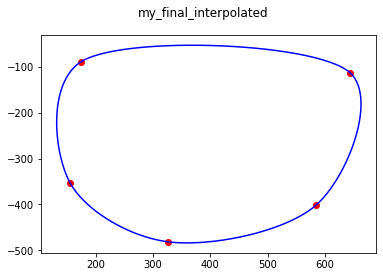

In [435]:
my_finals_xs_values = my_optim_result.x
my_final_control_points = make_control_points(my_finals_xs_values, my_f_curve)
my_final_interpolated = make_curve_from_control_points(my_final_control_points)
plot_control_and_interpolate(my_final_control_points, my_final_interpolated, "my_final_interpolated")

In [436]:
# Solution complete
def fit_spline_catmull_rom(
    curve: PointsArray,
    nbControlPoints: int,
    alpha: float
  ) -> PointsArray:

    f_curve = curve_to_01_function(curve)
    initial_guess = np.linspace(0., 1., nbControlPoints, endpoint=False)    
    f_optim = make_function_to_minimize(curve)
    optim_result=scipy.optimize.minimize(
      f_optim, 
      initial_guess, 
      method='powell', # powelloptions={'maxfev': 1000, 'disp': True, 'xtol': 1e-2},
    )

    xs = optim_result.x
    pts = []
    for x in xs:
      pts.append(f_curve(x))
    r = np.array(pts)
    return r

nb_calls=100 dist=6.567456619332103
nb_calls=200 dist=33.459532824068276
nb_calls=300 dist=3.990938372076074
nb_calls=400 dist=3.819120421748235
nb_calls=500 dist=3.7857990857617687
nb_calls=600 dist=17.004060893091427


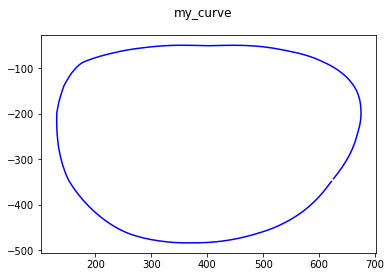

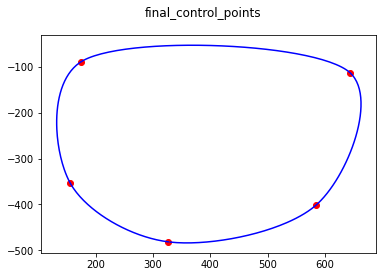

In [439]:
# Demo
plot_curve(my_curve, "my_curve")
final_control_points =  fit_spline_catmull_rom(my_curve, 5, 0.4)
final_interpolate = make_curve_from_control_points(final_control_points)
plot_control_and_interpolate(final_control_points, final_interpolate, "final_control_points")